In [237]:
library(ggplot2)
options(warn = -1)

# Exploration: Empirical CDF, Inverse Transform Sampling and the Newsvendor Inventory Model

Suppose we have at our disposal a random sample of observations X with an unknown distribution.

Question 1: Can we obtain a cumulative distribution function based on this random sample?

Question 2: Can we obtain the inverted CDF of such a cdf in question 1 that we can use to obtain a new random sample with the same unknown distribution (inverse-transform sampling)?


For this simple R Implementation I use X ~ Exp(λ=0.5) with 200 samples but in fact we can use any random sample we want to answer both of the questions above. The cdf of the exponential distribution is easily invertible and hence it will be easy to evaluate results that follow.



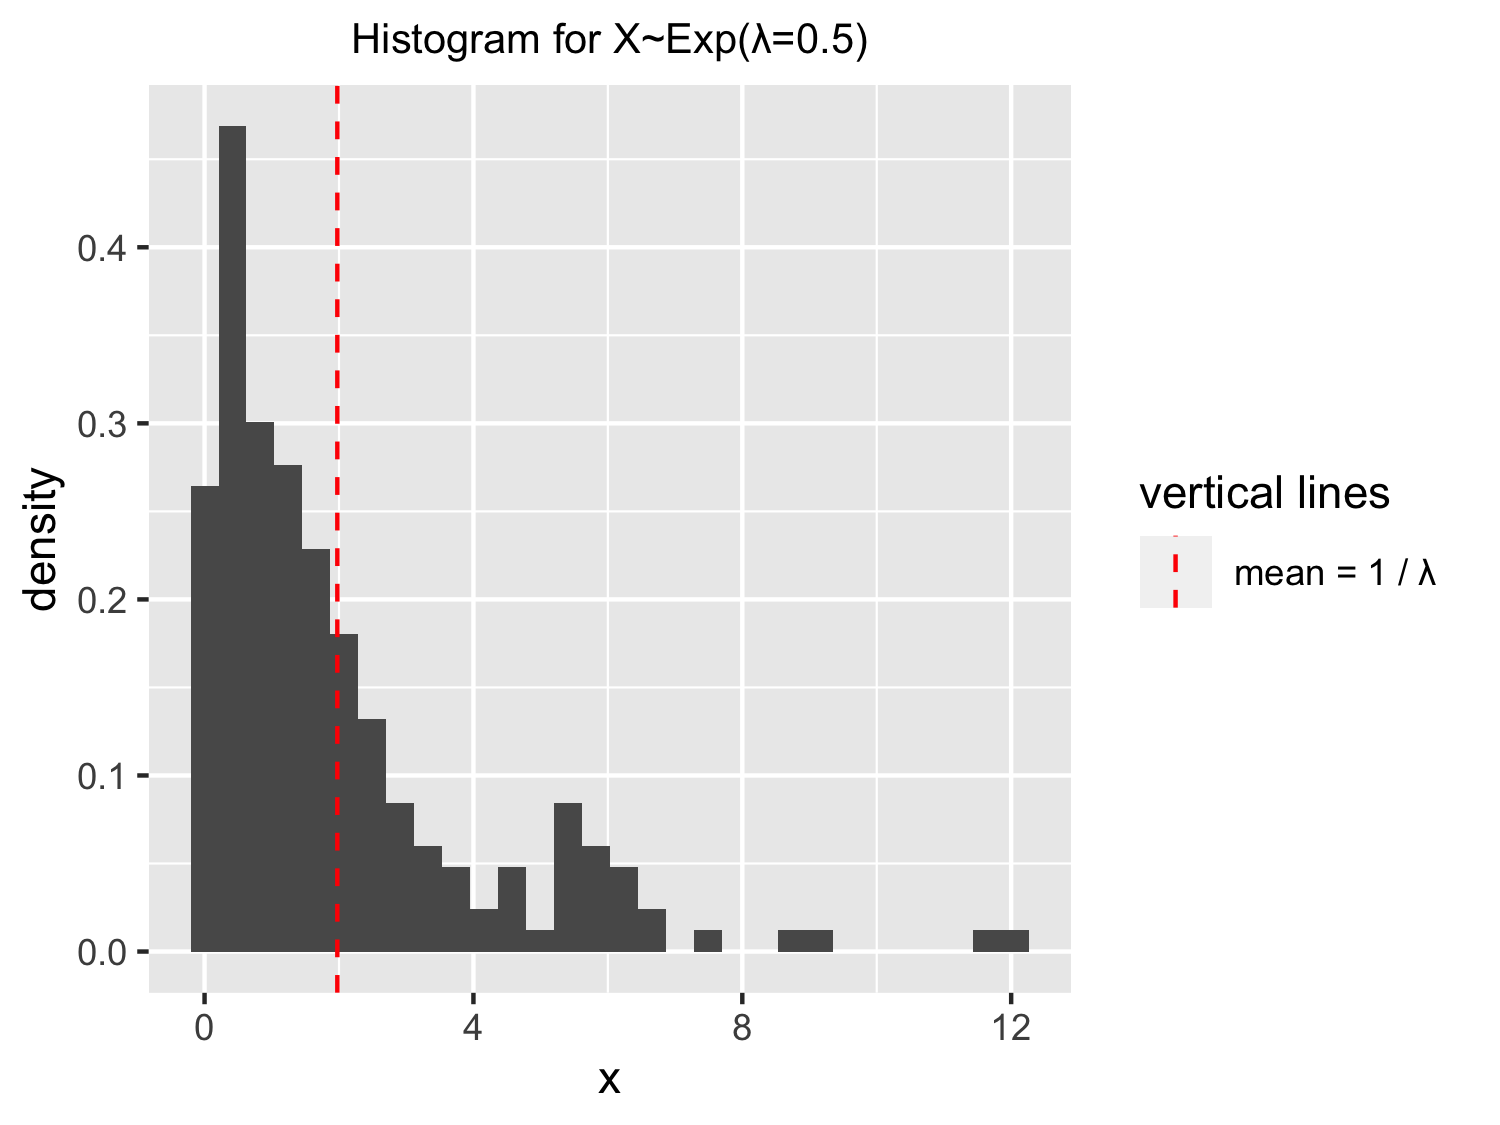

In [238]:
N=200
x<-rexp(rate=0.5,n=N) # generate random sample of 200 data points from the exponential distribution
#next line produces a simple histogram of the sample generated
ggplot(data.frame(x),aes(x=x))+geom_histogram(bins=30,aes(y = ..density..))+
ggtitle("Histogram for X~Exp(λ=0.5)")+
theme(plot.title = element_text(hjust = 0.5,size=10)) +
geom_vline(xintercept=mean(x), linetype="dashed", color = "red",show_guide=T)+
scale_color_manual("vertical lines",values=c("mean = 1 / λ "="red"))

**Empirical CDF is Defined**:
<br>

F(x) = $\sum_{i=1}^{n}I_{x>i}$ / n

where n = size of sample 

(definition taken from Larry Wasserman All of Statistics page 97)

<br>

**Inverse Empirical CDF**

$F^{−1} : [0, 1] → \mathbf{R}$

$F^{-1}(u)$ = min$\{x:u\in\mathbb[0,1]\text{ and }F(x) \ge u\} $

note the added complexity that unlike our gamma distribution cdf, the empirical cdf may not be strictly monotone and hence the minimum (or strictly speaking infimum) are used to address this. (cdf's must be weakly monotone and right continuous)


In [239]:
F <- function (m){# empirical cdf
    s=0
    for (i in 1:length(x)){
        if (x[i]<m){s=s+1}}
    return (s/N)}
F_inv <- function(u,F){# inverse empirical cdf
    s<-c()
    for (i in seq(from = 0, to = 15, length.out = 300)  ){
        if (F(i)>=u){
            s<-c(s,i)}   } 
    if (length(s) !=0){ 
        return (min(s))} 
    else {return (15)}   }

In [240]:
y<-c()
for (i in 1:length(x)){y = c(y,F(x[i]))}
u = seq(from = 0, to = 1, length.out = N)
y2<- c()
for (i in 1:length(u)){y2 = c(y2,F_inv(u[i],F))}

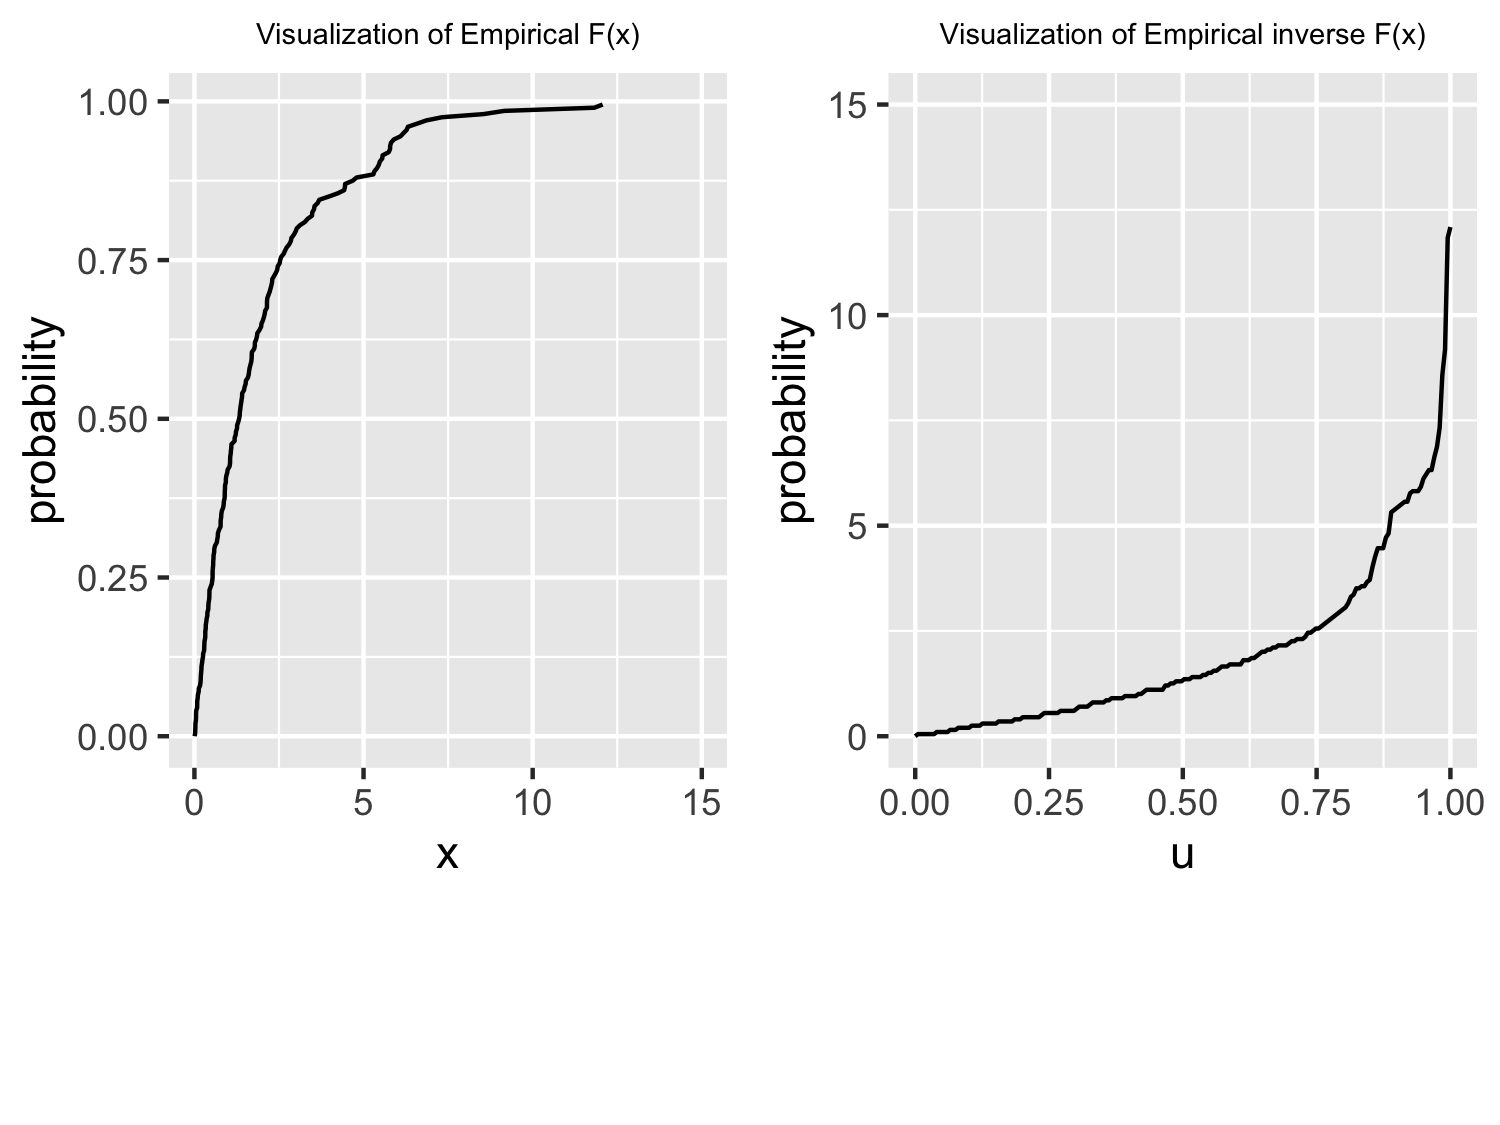

In [241]:
graph1<-ggplot(data.frame(x,y),aes(x=x,y=y))+geom_line()+
xlim(0,15)+ggtitle("Visualization of Empirical F(x)")+
ylab('probability')+theme(plot.title = element_text(hjust = 0.5,size=7))
graph2<-ggplot(data.frame(u,y2),aes(x=u,y=y2))+geom_line()+
ylim(0,15)+ggtitle("Visualization of Empirical inverse F(x)")+
ylab('probability')+
theme(plot.title = element_text(hjust = 0.5,size=7))
library("ggplot2")
library("gridExtra")
options(repr.plot.width = 5, repr.plot.height = 3.75, repr.plot.res = 300)
grid.arrange(graph1, graph2, ncol = 2,heights=c(4,1))

Sanity Check!! But how do the above correspond to the actual Exp(λ=0.5) cdf that we know X came from?

Recall the Exponential distribution is characterized by the cdf.

<br>

$ F_{X}(x;\lambda) = \begin{cases}
\  1-e^{ - \lambda x} & x \ge 0, \\
0 & x < 0.
\end{cases}$

<br>


In [242]:
cdf <- function(x) {1-exp(-0.5*x)} # true cdf function
X<-seq(0,5,length.out=N) # x-axis sample points
emp_cdf_y=c() # probability y-axis points for the empirical cdf
for (i in X){emp_cdf_y<-c(emp_cdf_y,F(i))}
true_y=c() # actual y probability values for the true cdf
for (i in X){true_y<-c(true_y,cdf(i))} 

We can use the Dvoretzky-Kiefer-Wolfowitz Inequality calculate confidence intervals for our Empirical CDF to give us a sense of the accuracy of the estimated cdf as follows:

<br>

The inequality states that for $X_{i} ~ F$ where i = 1,...n 

<br>

for any k>0,

<br>

$$P(sum|F(x)-F^{*}_{n}|> k) \le2e^{-2nk^{2}}$$

Thus we have $$L(x) = max (F^{*}(x) - k_{n},0)$$
and  $$U(x) = min (F^{*}(x) + k_{n},1)$$
where$$ k_{n} = \sqrt(\frac{1}{2n}log \frac{2}{a})$$

s.t. for any F, $$P(L(x) \le F(x) \le U(x) ) \ge 1-a $$


In [243]:
U=c()
a=0.05
#for (i in X){emp_cdf_y<-c(emp_cdf_y,F(i))}
for (i in X){U<-c(U,F(i)+sqrt((1/2/N)*log(2/a)))}
L=c()
for (i in X){L<-c(L,F(i)-sqrt((1/2/N)*log(2/a)))}

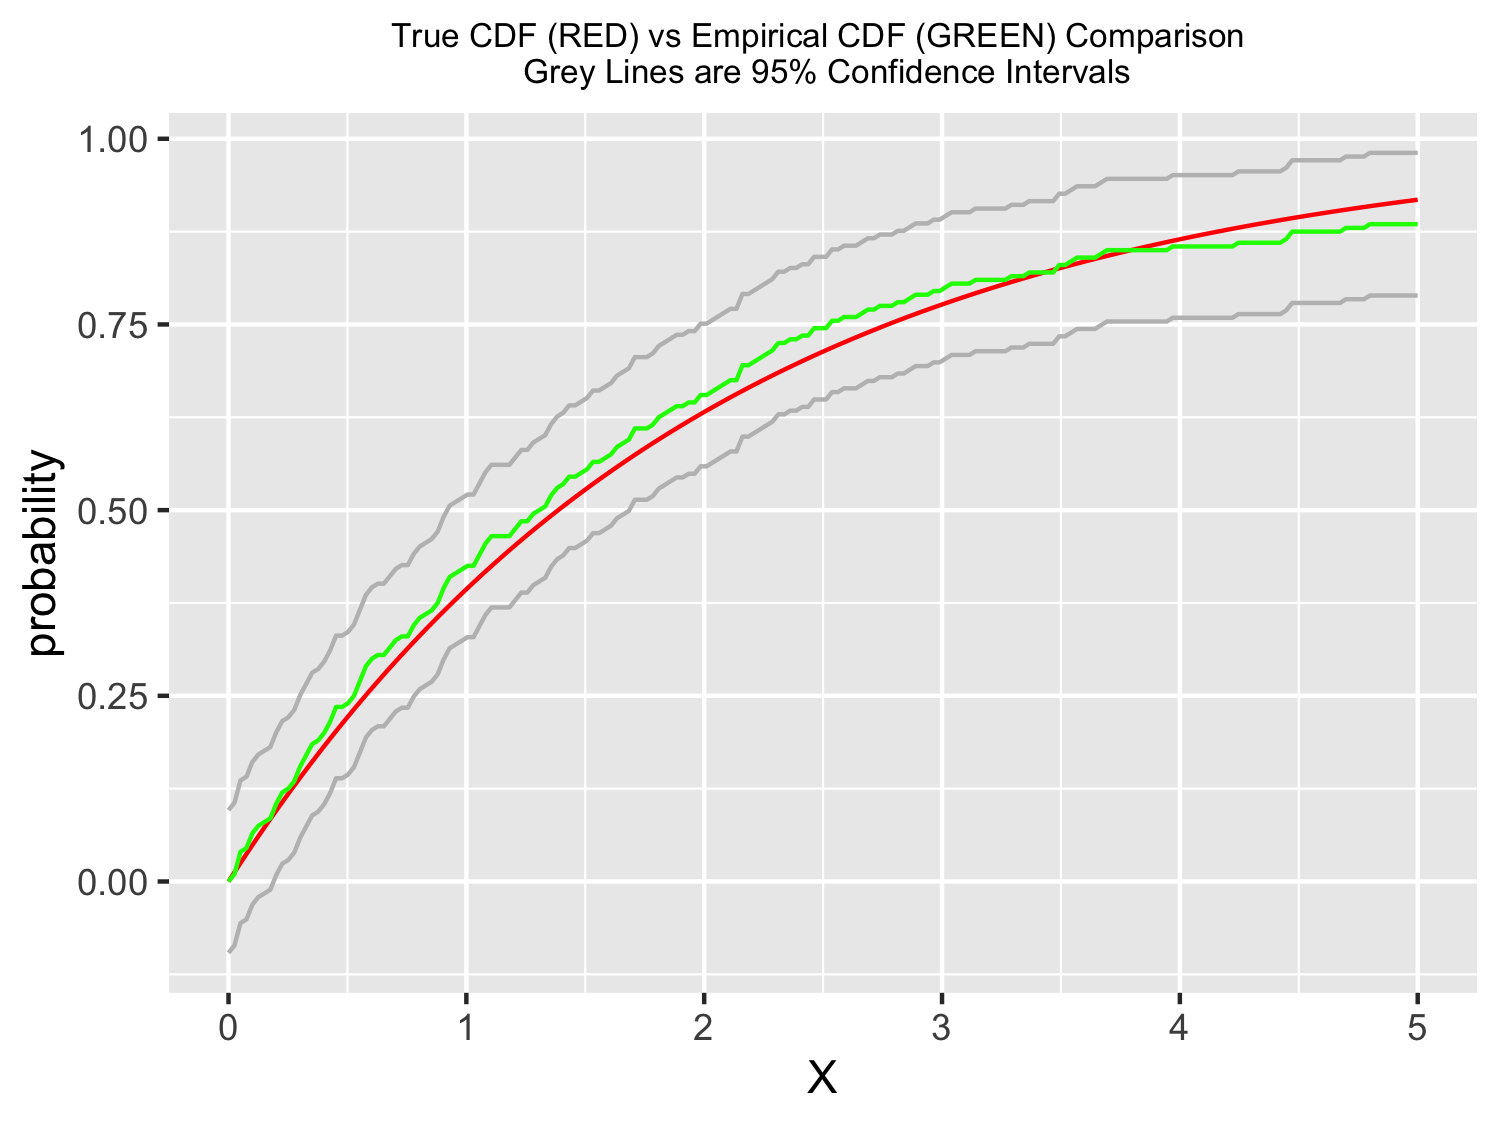

In [244]:
ggplot()+
geom_line(aes(x=X,y=true_y),color="red")+
geom_line(aes(x=X,y=emp_cdf_y),color="green")+
geom_line(aes(x=X,y=L),color="grey")+
geom_line(aes(x=X,y=U),color="grey")+
ggtitle('True CDF (RED) vs Empirical CDF (GREEN) Comparison \n Grey Lines are 95% Confidence Intervals')+
theme(plot.title = element_text(hjust = 0.5,size=8))+ylab('probability')


from the above we can observe that even with 1000 data points in this case the empirical cdf that we have obtained very closely matches the true cdf 

<br>

but what about the inverse cdf? how does our inverse cdf compare to the true inverse cdf given that we know the distribution where the random sample came from?

<br>

for $x\ge 0$ we can rearrange the cdf definition to obtain: $x = \frac{ln(1-F(x)}{-λ}$ which in our case will become $x = F^{-1}(u)=-2*ln(1-u)$ 

<br>

We can generate a sample of observations $~ Uniform(0,1)$ via inverse transform sampling using $F^{-1}(u)$. 

<br>

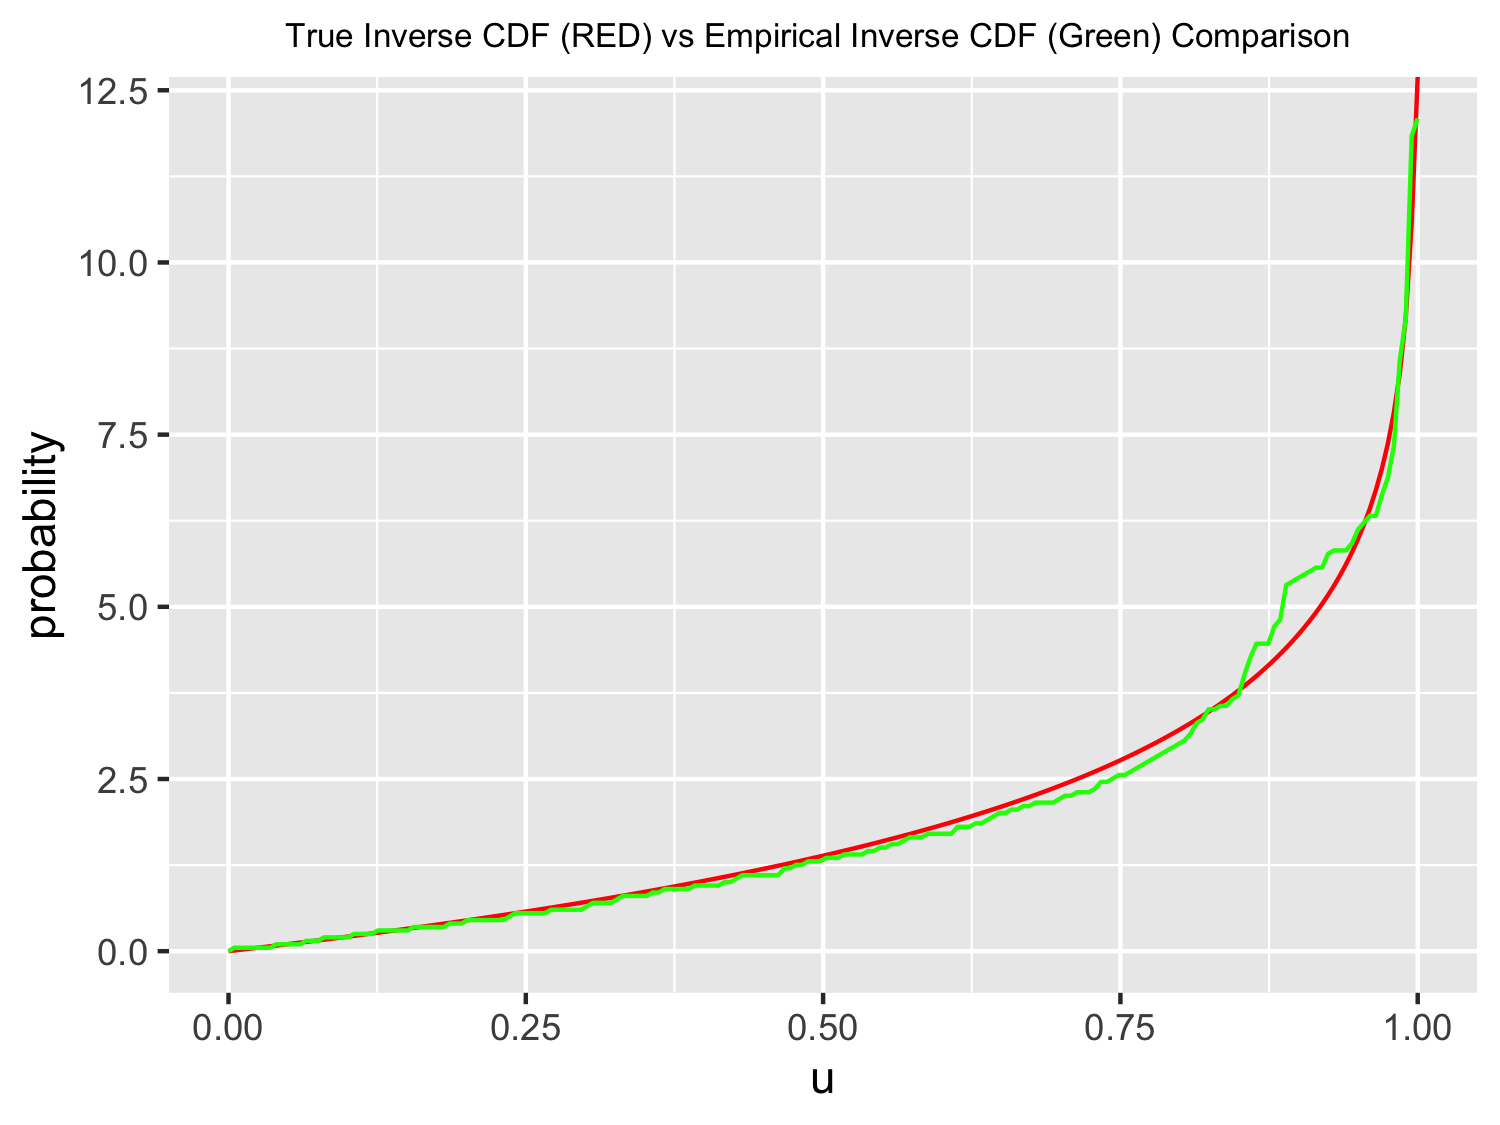

In [245]:
true_F_inv<-function(u){-2*log(1-u)}
true=c()
for (i in u){true<-c(true,true_F_inv(i))}
emp=c()
for (i in u){emp<-c(emp,F_inv(i,F))}
df<-data.frame(u,c(emp,true))
ggplot()+geom_line(aes(x=u,y=true),color="red")+
geom_line(aes(x=u,y=emp),color="green")+
ggtitle('True Inverse CDF (RED) vs Empirical Inverse CDF (Green) Comparison ')+
theme(plot.title = element_text(hjust = 0.5,size=8))+ylab('probability')

## Newsvendor Model
<br>

The Newsvendor model assume Sales = S ~ Normal (mu, sigma^2). 

<br>

We maximizing expected profit the single period optimal order quantity $q^{*}$.

<br>

Expected Profit = $E(p*min(S,q)-q*c-FC)$ 

where p = price for the newspaper, c= variable cost per unit, FC=fixed cost

<br>

$I(q)$ = $p\int_{-\infty}^{\infty} min(v,q) dv - q*c - FC =  p\int_{-\infty}^{q} vdv -p\int_{q}^{\infty}qdv- q*c - FC $
$\frac{dI}{dq}=p*q*f(q) +p(1-F(q))-p*q*f(q) - c$ where f is the pdf of r.v. S

<br>

set $\frac{dI}{dq}=0$ to obtain $F_{S}(q^{*})$  = $\frac{(p - c)}{p}$ 

<br>

$\frac{\partial^2 I}{\partial q^2} = -p*f(q) <0 $ hence I(q) is convex so $q^{*}$ maximizes our expected profit $I(q)$

<br>

if S is normally distributed this translates to $q^{*} = Φ^{-1}(\frac{p-c}{p})$

<br>

**but what if S is not normally distributed?**
<br>

**in this case we can use our inverse empirical cdf described above in order to find the optimal order quantity q to help the newsvendor!**